In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
## Load the required modules

from sklearn.model_selection import StratifiedKFold, cross_val_score, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

In [11]:
# Reading the merged datasets

data_merged_MP = pd.read_csv('data_merged_MP.csv', index_col=0)
data_merged_MP_only = pd.read_csv('data_merged_MP_only.csv', index_col=0)
data_merged_NoS = pd.read_csv('data_merged_NoS.csv', index_col=0)
data_merged_Ratio = pd.read_csv('data_merged_Ratio.csv', index_col=0)

In [3]:
fraud_npi = [1003816141, 1013010685, 1114913761, 1124131958, 1124150065, 1134232648, 1275626897, 
             1285622662, 1306023973, 1326230822, 1386989440, 1477573319, 1518046754, 1528054640, 
             1649316753, 1720096829, 1720123110, 1740210236, 1760566566, 1780609933, 1821273137, 
             1861470783, 1932270097]


non_fraud_npi = [1124040209, 1154430460, 1154439743, 1164531430, 1225072481, 1235234634, 1295736916, 
                 1316980014, 1396798484, 1447267505, 1457457483, 1457468514, 1477504405, 1497864664, 
                 1497943914, 1528043023, 1528177706, 1538265632, 1548294101, 1588678841, 1629177241, 
                 1669560041, 1679884472, 1689601635, 1689773244, 1699725507, 1700985496, 1770684938, 
                 1912968496,  1922072966, 1942455423, 1962525279, 1992804504]


flag = pd.Series(data=['unlabeled'] * len(data_merged_MP.index), index=data_merged_MP.index, dtype='str', name='flag')
for npi in non_fraud_npi:
     flag.at[npi] = 'non-fraudulent'
for npi in fraud_npi:
    flag.at[npi] = 'fraudulent'

## Data to work with

In [51]:
data_merged = [data_merged_MP.copy(), data_merged_MP_only.copy(), data_merged_NoS.copy(), data_merged_Ratio.copy()]
    
x = []
for i in range(len(data_merged)):
    vals = data_merged[i].values
    z = np.zeros((vals.shape[0], int(vals.shape[1] / 7)))
    for r in range(z.shape[0]):
        for c in range(z.shape[1]):
            z[r, c] = np.mean(vals[r, c * 7 : (c+1) * 7])
    clmns = [hcpcs[0:5] for hcpcs in data_merged[i].columns]
    clmns = list(set(clmns))
    clmns.sort()
    df = pd.DataFrame(data=z, index=data_merged[i].index, columns=clmns, dtype='float64')
    x.append(df)
        
    
[x_MP, x_MP_only, x_NoS, x_Ratio] = x 

kf = StratifiedKFold(4, shuffle=True, random_state=0)

In [86]:
import warnings
warnings.filterwarnings('ignore')

best_scores_svm = []
best_scores_lgr = []

for n in range(10):
    percentile = n * 10
    print(percentile)
    inds = set()
    
#     total_payments = []
#     for hcpcs in x_MP_only.columns:
#         total_payments.append(np.mean(x_MP_only[hcpcs].values))
#     val = np.percentile(total_payments, percentile)
#     for i in range(len(total_payments)):
#         if total_payments[i] > val:
#             inds.add(i)

    total_Ratio = []
    for hcpcs in x_Ratio.columns:
        total_Ratio.append(np.mean(x_Ratio[hcpcs].values))
    val = np.percentile(total_Ratio, 100 - percentile)
    for i in range(len(total_Ratio)):
        if total_Ratio[i] < val:
            inds.add(i)
            
    print(len(inds))
    
    x_MP_subset = x_MP.copy().iloc[:,list(inds)]
    x_NoS_subset = x_NoS.copy().iloc[:,list(inds)]
    x_Ratio_subset  = x_Ratio.copy().iloc[:,list(inds)]
    
    x_MP_train, x_MP_unlabeled = x_MP_subset.loc[flag != 'unlabeled'], x_MP_subset.loc[flag == 'unlabeled']
    x_NoS_train, x_NoS_unlabeled = x_NoS_subset.loc[flag != 'unlabeled'], x_NoS_subset.loc[flag == 'unlabeled']
    x_Ratio_train, x_Ratio_unlabeled = x_Ratio_subset.loc[flag != 'unlabeled'], x_Ratio_subset.loc[flag == 'unlabeled']

    y_train = flag[flag != 'unlabeled']
    
    ## Logistic Regression and SVM

    x_train = [x_MP_train, x_NoS_train, x_Ratio_train]

    C_grid = np.logspace(-4,3,10)

    score_best_lr = []
    score_best_svm= []
    C_best_lr = []
    C_best_svm = []

    for x in x_train:
        scores_lr = []
        scores_svm = []
        for C in C_grid:
            clf_lr = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(C=C, max_iter=1e7))])
            clf_svm = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC(C=C, max_iter=1e7))])
            scores_lr.append(cross_val_score(clf_lr, x, y_train, cv=kf).mean())
            scores_svm.append(cross_val_score(clf_svm, x, y_train, cv=kf).mean())
        score_best_lr.append(np.max(scores_lr)) 
        score_best_svm.append(np.max(scores_svm)) 
        C_best_lr.append(C_grid[np.argmax(scores_lr)])
        C_best_svm.append(C_grid[np.argmax(scores_svm)])

        
    best_scores_lgr.append(np.mean(score_best_lr))
    best_scores_svm.append(np.mean(score_best_svm))
    print('Best scores logistic regression:', score_best_lr)
    print('Best hyperparameters logistic regression:', C_best_lr)
    print('\n')
    print('Best scores svm:', score_best_svm)
    print('Best hyperparameters svm:', C_best_svm)

0
516
Best scores logistic regression: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0005994842503189409, 0.0005994842503189409, 0.021544346900318846]


Best scores svm: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters svm: [0.0001, 0.0001, 0.003593813663804626]
10
465
Best scores logistic regression: [0.8030219780219781, 0.7863553113553113, 0.8401098901098901]
Best hyperparameters logistic regression: [0.003593813663804626, 0.003593813663804626, 0.0005994842503189409]


Best scores svm: [0.7837912087912089, 0.7863553113553113, 0.8401098901098901]
Best hyperparameters svm: [0.0005994842503189409, 0.0005994842503189409, 0.0001]
20
413
Best scores logistic regression: [0.7123626373626375, 0.7302197802197803, 0.7480769230769231]
Best hyperparameters logistic regression: [4.641588833612782, 4.641588833612782, 0.774263682681127]


Best scores svm: [0.7135531135531135, 0.6943223443223443, 0.714743589

Text(0, 0.5, 'SVM Prediction accuracy')

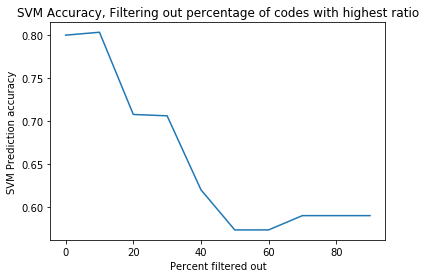

In [89]:
plt.plot([n * 10 for n in range(10)], best_scores_svm)
plt.title("SVM Accuracy, Filtering out percentage of codes with highest ratio")
plt.xlabel("Percent filtered out")
plt.ylabel("SVM Prediction accuracy")

Text(0, 0.5, 'LGR Prediction accuracy')

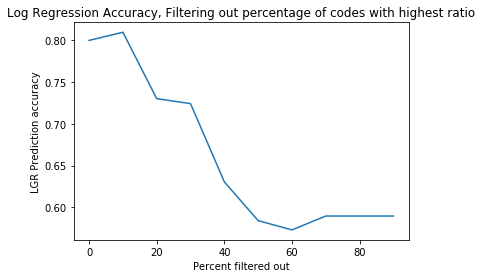

In [90]:
plt.plot([n * 10 for n in range(10)], best_scores_lgr)
plt.title("Log Regression Accuracy, Filtering out percentage of codes with highest ratio")
plt.xlabel("Percent filtered out")
plt.ylabel("LGR Prediction accuracy")

In [102]:
import warnings
warnings.filterwarnings('ignore')

best_scores_svm = []
best_scores_lgr = []

for n in range(10):
    percentile = n * 10
    print(percentile)
    inds = set()
    
    total_payments = []
    for hcpcs in x_MP_only.columns:
        total_payments.append(np.mean(x_MP_only[hcpcs].values))
    val = np.percentile(total_payments, percentile)
    for i in range(len(total_payments)):
        if total_payments[i] > val:
            inds.add(i)

#     total_Ratio = []
#     for hcpcs in x_Ratio.columns:
#         total_Ratio.append(np.mean(x_Ratio[hcpcs].values))
#     val = np.percentile(total_Ratio, 100 - percentile)
#     for i in range(len(total_Ratio)):
#         if total_Ratio[i] < val:
#             inds.add(i)
            
    print(len(inds))
    
    x_MP_subset = x_MP.copy().iloc[:,list(inds)]
    x_NoS_subset = x_NoS.copy().iloc[:,list(inds)]
    x_Ratio_subset  = x_Ratio.copy().iloc[:,list(inds)]
    
    x_MP_train, x_MP_unlabeled = x_MP_subset.loc[flag != 'unlabeled'], x_MP_subset.loc[flag == 'unlabeled']
    x_NoS_train, x_NoS_unlabeled = x_NoS_subset.loc[flag != 'unlabeled'], x_NoS_subset.loc[flag == 'unlabeled']
    x_Ratio_train, x_Ratio_unlabeled = x_Ratio_subset.loc[flag != 'unlabeled'], x_Ratio_subset.loc[flag == 'unlabeled']

    y_train = flag[flag != 'unlabeled']
    
    ## Logistic Regression and SVM

    x_train = [x_MP_train, x_NoS_train, x_Ratio_train]

    C_grid = np.logspace(-4,3,10)

    score_best_lr = []
    score_best_svm= []
    C_best_lr = []
    C_best_svm = []

    for x in x_train:
        scores_lr = []
        scores_svm = []
        for C in C_grid:
            clf_lr = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(C=C, max_iter=1e7))])
            clf_svm = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC(C=C, max_iter=1e7))])
            scores_lr.append(cross_val_score(clf_lr, x, y_train, cv=kf).mean())
            scores_svm.append(cross_val_score(clf_svm, x, y_train, cv=kf).mean())
        score_best_lr.append(np.max(scores_lr)) 
        score_best_svm.append(np.max(scores_svm)) 
        C_best_lr.append(C_grid[np.argmax(scores_lr)])
        C_best_svm.append(C_grid[np.argmax(scores_svm)])

        
    best_scores_lgr.append(np.mean(score_best_lr))
    best_scores_svm.append(np.mean(score_best_svm))
    print('Best scores logistic regression:', score_best_lr)
    print('Best hyperparameters logistic regression:', C_best_lr)
    print('\n')
    print('Best scores svm:', score_best_svm)
    print('Best hyperparameters svm:', C_best_svm)

0
516
Best scores logistic regression: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0005994842503189409, 0.0005994842503189409, 0.021544346900318846]


Best scores svm: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters svm: [0.0001, 0.0001, 0.003593813663804626]
10
465
Best scores logistic regression: [0.7696886446886446, 0.7696886446886446, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0001, 0.0001, 0.021544346900318846]


Best scores svm: [0.7696886446886446, 0.7863553113553113, 0.8030219780219781]
Best hyperparameters svm: [0.0001, 0.003593813663804626, 0.003593813663804626]
20
413
Best scores logistic regression: [0.7696886446886446, 0.7696886446886446, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0001, 0.0001, 0.021544346900318846]


Best scores svm: [0.7696886446886446, 0.7696886446886446, 0.8030219780219781]
Best hyperparameters svm: [0.0001, 0.0001

Text(0, 0.5, 'SVM Prediction accuracy')

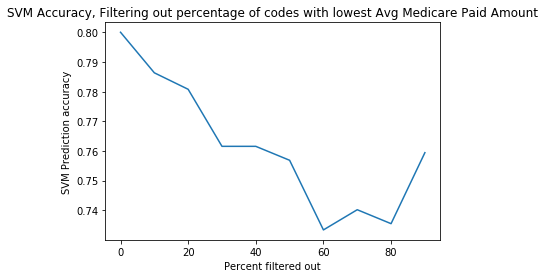

In [105]:
plt.plot([n * 10 for n in range(10)], best_scores_svm)
plt.title("SVM Accuracy, Filtering out percentage of codes with lowest Avg Medicare Paid Amount")
plt.xlabel("Percent filtered out")
plt.ylabel("SVM Prediction accuracy")

Text(0, 0.5, 'LGR Prediction accuracy')

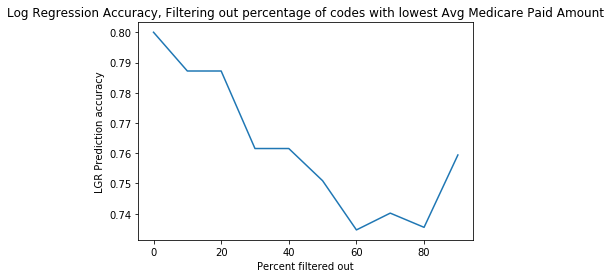

In [106]:
plt.plot([n * 10 for n in range(10)], best_scores_lgr)
plt.title("Log Regression Accuracy, Filtering out percentage of codes with lowest Avg Medicare Paid Amount")
plt.xlabel("Percent filtered out")
plt.ylabel("LGR Prediction accuracy")

In [95]:
import warnings
warnings.filterwarnings('ignore')

best_scores_svm = []
best_scores_lgr = []

for n in range(10):
    percentile = n * 10
    print(percentile)
    inds = set()
    
    total_payments = []
    for hcpcs in x_MP_only.columns:
        total_payments.append(np.mean(x_MP_only[hcpcs].values))
    val = np.percentile(total_payments, percentile)
    for i in range(len(total_payments)):
        if total_payments[i] > val:
            inds.add(i)

    total_Ratio = []
    for hcpcs in x_Ratio.columns:
        total_Ratio.append(np.mean(x_Ratio[hcpcs].values))
    val = np.percentile(total_Ratio, 90)
    for i in range(len(total_Ratio)):
        if total_Ratio[i] < val:
            inds.add(i)
            
    print(len(inds))
    
    x_MP_subset = x_MP.copy().iloc[:,list(inds)]
    x_NoS_subset = x_NoS.copy().iloc[:,list(inds)]
    x_Ratio_subset  = x_Ratio.copy().iloc[:,list(inds)]
    
    x_MP_train, x_MP_unlabeled = x_MP_subset.loc[flag != 'unlabeled'], x_MP_subset.loc[flag == 'unlabeled']
    x_NoS_train, x_NoS_unlabeled = x_NoS_subset.loc[flag != 'unlabeled'], x_NoS_subset.loc[flag == 'unlabeled']
    x_Ratio_train, x_Ratio_unlabeled = x_Ratio_subset.loc[flag != 'unlabeled'], x_Ratio_subset.loc[flag == 'unlabeled']

    y_train = flag[flag != 'unlabeled']
    
    ## Logistic Regression and SVM

    x_train = [x_MP_train, x_NoS_train, x_Ratio_train]

    C_grid = np.logspace(-4,3,10)

    score_best_lr = []
    score_best_svm= []
    C_best_lr = []
    C_best_svm = []

    for x in x_train:
        scores_lr = []
        scores_svm = []
        for C in C_grid:
            clf_lr = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(C=C, max_iter=1e7))])
            clf_svm = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC(C=C, max_iter=1e7))])
            scores_lr.append(cross_val_score(clf_lr, x, y_train, cv=kf).mean())
            scores_svm.append(cross_val_score(clf_svm, x, y_train, cv=kf).mean())
        score_best_lr.append(np.max(scores_lr)) 
        score_best_svm.append(np.max(scores_svm)) 
        C_best_lr.append(C_grid[np.argmax(scores_lr)])
        C_best_svm.append(C_grid[np.argmax(scores_svm)])

        
    best_scores_lgr.append(np.mean(score_best_lr))
    best_scores_svm.append(np.mean(score_best_svm))
    print('Best scores logistic regression:', score_best_lr)
    print('Best hyperparameters logistic regression:', C_best_lr)
    print('\n')
    print('Best scores svm:', score_best_svm)
    print('Best hyperparameters svm:', C_best_svm)

0
517
Best scores logistic regression: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0005994842503189409, 0.0005994842503189409, 0.021544346900318846]


Best scores svm: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters svm: [0.0001, 0.0001, 0.003593813663804626]
10
516
Best scores logistic regression: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0005994842503189409, 0.0005994842503189409, 0.021544346900318846]


Best scores svm: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters svm: [0.0001, 0.0001, 0.003593813663804626]
20
515
Best scores logistic regression: [0.7889194139194139, 0.7889194139194139, 0.8222527472527473]
Best hyperparameters logistic regression: [0.0005994842503189409, 0.0005994842503189409, 0.021544346900318846]


Best scores svm: [0.7889194139194139, 0.7889194139194139, 0.8222527472527

Text(0, 0.5, 'SVM Prediction accuracy')

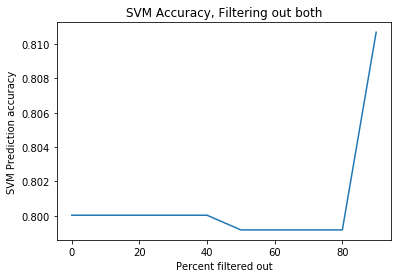

In [98]:
plt.plot([n * 10 for n in range(10)], best_scores_svm)
plt.title("SVM Accuracy, Filtering out both")
plt.xlabel("Percent filtered out")
plt.ylabel("SVM Prediction accuracy")

Text(0, 0.5, 'LGR Prediction accuracy')

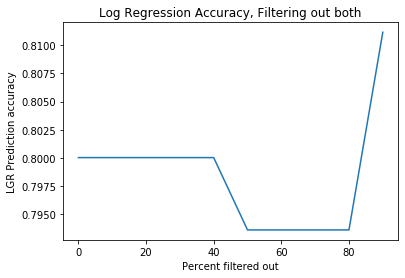

In [99]:
plt.plot([n * 10 for n in range(10)], best_scores_lgr)
plt.title("Log Regression Accuracy, Filtering out both")
plt.xlabel("Percent filtered out")
plt.ylabel("LGR Prediction accuracy")

## Labeling the unlabeled data

In [35]:
x_train = x_NoS_train
clf = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC(C=0.0036, max_iter=1e6))])
new_labels = clf.fit(x_train, y_train).predict(x_NoS_unlabeled)

In [39]:
new_fraud_npi = x_NoS_unlabeled[new_labels == 'fraudulent'].index

In [81]:
## Extracting names corresponding to the fraudulent npis

data2018 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2018_CA_Ophthalmology.csv')
data2017 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2017_CA_Ophthalmology.csv')
data2016 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016_CA_Ophthalmology.csv')
data2015 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2015_CA_Ophthalmology.csv')
data2014 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2014_CA_Ophthalmology.csv')
data2013 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2013_CA_Ophthalmology.csv')
data2013 = data2013.rename(columns={'National Provider Identifier ':'National Provider Identifier'})
data2012 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2012_CA_Ophthalmology.csv')


In [88]:
df = pd.DataFrame(index=new_fraud_npi, columns=['Last Name', 'First Name'], dtype='str')

for npi in new_fraud_npi:
    d = data2012.loc[data2012['National Provider Identifier'] == npi]
    if d.shape[0] != 0:
        df.loc[npi] = d.iloc[0][['Last Name/Organization Name', 'First Name']].values

df.to_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\LoN_Feb28.csv')